Multi-fidelity Modeling and Experimental Design (Active Learning)

In [1]:
# General imports

import numpy as np
np.random.seed(20)
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
import sys
import os
sys.path.append('../utilities')
import drawing_utils
import simulation_utils

In [2]:
%matplotlib inline
import GPy
import emukit.multi_fidelity
import emukit.test_functions
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from emukit.experimental_design.acquisitions import ModelVariance,IntegratedVarianceReduction
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter

In [3]:
version = 'v2'
if not os.path.exists(f'out/{version}'):
   os.makedirs(f'out/{version}')
labels=['Radius','Thickness','NPanels', 'Theta', 'Length']
xmin=[0,0,5,0,0]
xmax=[265,20,360,45,150]

xlow=[90,1,4,0,1]
xhigh=[250,20,360,45,150]

data = np.genfromtxt(f'in/Ge77_rates_{version}.csv',
                     dtype=None,
                     delimiter=',',
                    skip_header = 2)
print(data)

[(  0, b'LF', 4., 124., 16., 196.,  105.23714604, 18.,   3. , 300. ,  42., 4.79280691e+06,  37,  6.08276253, 0.00031852, 5.23732682e-05, 0.01153609, 0.00191105, 0.00190866,   50000,  123426)
 (  1, b'LF', 4., 200.,  7., 230.,   89.68035054, 27., 134. , 300. ,  42., 6.66065975e+07,  41,  6.40312424, 0.000391  , 6.10766555e-05, 0.01413861, 0.00222686, 0.00222292,   50000,  111594)
 (  2, b'LF', 4., 139.,  8.,  95.,  217.12084868,  4.,  17. , 300. ,  42., 4.96218681e+06,  31,  5.56776436, 0.00026388, 4.74011622e-05, 0.0095664 , 0.00172921, 0.00174904,   50000,  124703)
 (  3, b'LF', 4., 198.,  7., 357.,   57.77725665, 28.,  45. , 300. ,  42., 3.55848560e+07,  40,  6.32455532, 0.00035837, 5.66731634e-05, 0.01296472, 0.00206689, 0.00205468,   50000,  118730)
 (  4, b'LF', 4., 116., 11.,  67.,  307.85791977,  7., 144. , 300. ,  42., 3.29531564e+07,  29,  5.38516481, 0.00025435, 4.72368364e-05, 0.0092024 , 0.00171912, 0.00169418,   50000,  121272)
 (  5, b'LF', 4., 130.,  3., 271.,   76.11247

 /var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_14277/4246133629.py:11: VisibleDeprecationWarning:Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [4]:

x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
n_low_fidelity_points = 0
n_high_fidelity_points = 0
error_low = []
error_hi = []

for entry in data:
    if entry[1] == b'LF':
        #if (entry[5]==360 and entry[6]==0 and entry[7]==0) or entry[2] == 2 or entry[2] == 0 or entry[2] == 3:
        #    x_train_l.append([entry[3],entry[4],0.,entry[6],entry[7]])
        #else:
        #    x_train_l.append([entry[3],entry[4],360./entry[5],entry[6],entry[7]])
        x_train_l.append([entry[3],entry[4],entry[5],entry[7],entry[8]])
        y_train_l.append(entry[-5])
        error_low.append(entry[-3])
    else:
        #if (entry[5]==360 and entry[6]==0 and entry[7]==0) or entry[2] == 2 or entry[2] == 0 or entry[2] == 3:
        #    x_train_h.append([entry[3],entry[4],0.,entry[6],entry[7]])
        #else:
        #    x_train_h.append([entry[3],entry[4],360./entry[5],entry[6],entry[7]])
        x_train_h.append([entry[3],entry[4],entry[5],entry[7],entry[8]])
        y_train_h.append(entry[-5])
        error_hi.append(entry[-3])

print(x_train_h)
x_train_l, x_train_h, y_train_l, y_train_h = (np.atleast_2d(x_train_l), np.atleast_2d(x_train_h), np.atleast_2d(y_train_l).T, np.atleast_2d(y_train_h).T)
X_train, Y_train = convert_xy_lists_to_arrays([x_train_l,x_train_h], [y_train_l,y_train_h])



[[95.0, 10.0, 360.0, 0.0, 0.0], [200.0, 10.0, 360.0, 0.0, 0.0]]


In [5]:
x,y,z,c = drawing_utils.GetFormated(x_train_l,0,1,2,y_train_l)
drawing_utils.draw_samples_distribution_3D_rotating(x,y,z,c)
x,y,z,c = drawing_utils.GetFormated(x_train_l,3,4,2,y_train_l)
drawing_utils.draw_samples_distribution_3D_rotating(x,y,z,c)

/Users/aschuetz/Documents/Analysis/legend/ML/legend-multi-fidelity-surrogate-model/surrogate-model/../utilities/drawing_utils.py:107: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



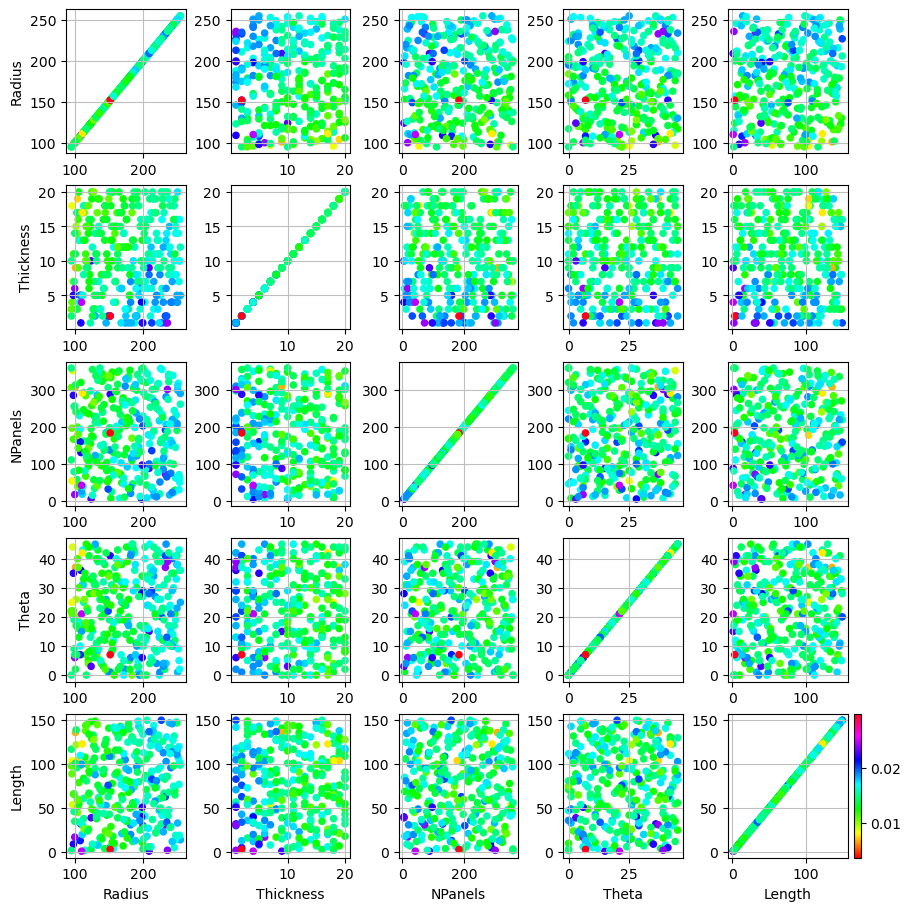

In [6]:
drawing_utils.DrawParameterCorrelations(x_train_l, y_train_l, labels)

In [7]:
# Construct a linear multi-fidelity model

kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
LF_noise = 0.00025629
gpy_lin_mf_model.mixed_noise.Gaussian_noise.fix(LF_noise)
'''
The Low Fidelity noise level need to be independently estimated. Here I provide a guess of 5e-7
'''
gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)

## Wrap the model using the given 'GPyMultiOutputWrapper'

lin_mf_model = model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=20)

## Fit the model
  
lin_mf_model.optimize()
nonlin_mf_model = lin_mf_model

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/core/gp.py:85: UserWarning:

Your kernel has a different input dimension 2 then the given X dimension 6. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel

/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/paramz/transformations.py:111: RuntimeWarning:

divide by zero encountered in log



Optimization restart 1/20, f = -968.6086400085456
Warning - optimization restart 2/20 failed
Warning - optimization restart 3/20 failed
Warning - optimization restart 4/20 failed
Warning - optimization restart 5/20 failed
Warning - optimization restart 6/20 failed
Warning - optimization restart 7/20 failed
Warning - optimization restart 8/20 failed
Warning - optimization restart 9/20 failed
Warning - optimization restart 10/20 failed
Warning - optimization restart 11/20 failed
Warning - optimization restart 12/20 failed
Warning - optimization restart 13/20 failed
Warning - optimization restart 14/20 failed
Warning - optimization restart 15/20 failed
Warning - optimization restart 16/20 failed
Warning - optimization restart 17/20 failed
Warning - optimization restart 18/20 failed
Warning - optimization restart 19/20 failed
Warning - optimization restart 20/20 failed


/Users/aschuetz/.local/modules/miniconda/miniconda3/envs/legend/lib/python3.10/site-packages/GPy/core/__init__.py:80: FutureWarning:

In the future `np.bool` will be defined as the corresponding NumPy scalar.



In [8]:
def IsWithinStdModelPredictionErrorBand(x,y,model,factor=1):
    x_plot = x
    #print(x_plot)
    #print(np.linspace(0, 265, 200)[:, None])
    X_plot = convert_x_list_to_array([x_plot, x_plot])
    mean, var = model.predict(X_plot[:len(x)])
    std= np.sqrt(var)
    upper_bound=mean+factor*std
    lower_bound=mean-factor*std
    y>mean+factor*std
    index=[]
    for i in range(len(y)):
        if y[i] < lower_bound[i] or y[i] > upper_bound[i]:
            index.append(i)
    return index
    

The model error band $\mu_{\rm model,LF} \pm f\cdot\sigma_{\rm LF}$ is chosen such that > 90 % of the LF samples lie within the error band in the 5 dimensional space

In [9]:
def DrawMultiFideliyModel(x_train_l,y_train_l,x_train_h,y_train_h,nonlin_mf_model,xmin, xmax, labels, factor=1., x_new_data=np.array([]),y_new_data=np.array([]), version='v1', x_fixed=[200., 10., 40., 45., 30.]):
    outlaying_indices=[]
    SPLIT = 100
    with PdfPages(f'out/{version}/neutron-moderator-multi-fidelity-model_{version}.pdf') as pdf:
        for i in range(0,5):   
            ## Compute mean and variance predictions
            x_plot=[x_fixed[:] for l in range(0,SPLIT)]
            x_tmp = np.linspace(xmin[i], xmax[i], SPLIT)
            for k in range(0,SPLIT):
                x_plot[k][i]=x_tmp[k]
            x_plot = (np.atleast_2d(x_plot))
            X_plot = convert_x_list_to_array([x_plot , x_plot])

            lf_mean_nonlin_mf_model, lf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot[:SPLIT])
            lf_std_nonlin_mf_model = np.sqrt(lf_var_nonlin_mf_model)
        
            hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot[SPLIT:])
            hf_std_nonlin_mf_model = np.sqrt(hf_var_nonlin_mf_model)

            ## Plot posterior mean and variance of nonlinear multi-fidelity model

            plt.figure(figsize=(12,8))
            #outlaying_indices.extend(IsWithinStdModelPredictionErrorBand(np.atleast_2d((x_train_l[:].T[i])).T,y_train_l,nonlin_mf_model,factor))
            #outlaying_indices=list(set(outlaying_indices))

            plt.fill_between(x_tmp.flatten(), (lf_mean_nonlin_mf_model - factor * lf_std_nonlin_mf_model).flatten(), 
                         (lf_mean_nonlin_mf_model + factor * lf_std_nonlin_mf_model).flatten(), color='y', alpha=0.3)
        
            plt.fill_between(x_tmp.flatten(), (hf_mean_nonlin_mf_model - hf_std_nonlin_mf_model).flatten(), 
                         (hf_mean_nonlin_mf_model + hf_std_nonlin_mf_model).flatten(), color='g', alpha=0.3)

            #print(lf_mean_nonlin_mf_model)
            plt.plot(x_tmp, lf_mean_nonlin_mf_model, '--', color='y')
            plt.plot(x_tmp, hf_mean_nonlin_mf_model, '--', color='g')
            plt.plot(np.atleast_2d((x_train_l[:].T[i])).T, y_train_l, 'b',marker=".",linewidth=0)
            plt.plot(np.atleast_2d((x_train_h[:].T[i])).T, y_train_h, 'r',marker=".",markersize=10,linewidth=0)

            if x_new_data.any() and y_new_data.any():
                plt.scatter(x_new_data[0][i], y_new_data[0][0], color="orange")
            plt.xlabel(labels[i])
            plt.ylabel('Ge77 Production Rate')
            plt.xlim(xmin[i], xmax[i])
            plt.legend([f'{factor} $\sigma$ Prediction Low Fidelity',f'{factor} $\sigma$ Prediction High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity', 'Low Fidelity Training Data', 'High Fidelity Training Data'])
            ##plt.legend()
            plt.title('linear multi-fidelity model fit to low and high fidelity functions');
            pdf.savefig()
            plt.show()
            
    #print(f'{np.round((1-len(outlaying_indices)/len(y_train_l))*100,1) }% within {factor} std.')



In [10]:
def DrawMultiFideliyModel3D(nonlin_mf_model,xmin, xmax, labels,index1=0,index2=3,index3=2,ml='HF',version='v1', x_fixed=[160., 5., 40., 45., 100.]):
    SPLIT=25
    i=index1
    j=index2
    m=index3
    xi_tmp = np.linspace(xmin[i], xmax[i], SPLIT)
    xj_tmp = np.linspace(xmin[j], xmax[j], SPLIT)
    xm_tmp = np.linspace(xmin[m], xmax[m], SPLIT)

    lf_mean=np.zeros((SPLIT*SPLIT,SPLIT))
    X, Y, Z = np.meshgrid(xi_tmp,xj_tmp, xm_tmp)

    for l,pair in enumerate(zip(Z,X,Y)): # -> range(SPLIT)
        vtmp=np.array(pair)

        for t in range(SPLIT): 
            x_plot=[x_fixed[:] for l in range(0,SPLIT)]
            x_plot = (np.atleast_2d(x_plot))
            x_plot[:].T[i]=vtmp[1][t]
            x_plot[:].T[j]=vtmp[2][t]
            x_plot[:].T[m]=vtmp[0][t]
            x_plot = (np.atleast_2d(x_plot))
            X_plot = convert_x_list_to_array([x_plot , x_plot])
            if ml=='LF':
                mean, _ = nonlin_mf_model.predict(X_plot[SPLIT:])
            else:
                mean, _ = nonlin_mf_model.predict(X_plot[:SPLIT])
            mean=np.array([k[0] for k in mean])
            lf_mean[l*SPLIT+t]=mean

    fig=plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlabel(labels[i])
    ax.set_ylabel(labels[j])
    ax.set_zlabel(labels[m])
    cz = ax.scatter(X,Y,Z,c=lf_mean,linewidth=0,antialiased=False, alpha=0.5)
    plt.colorbar(cz)
    plt.savefig(f'out/{version}/neutron-moderator-multi-fidelity-model-3D_{version}.png')
    plt.show()



In [11]:
def DrawUpdatedMultiFideliyModel(fig, x_train_l,y_train_l,x_train_h,y_train_h,nonlin_mf_model,xmin, xmax, labels, factor=1., x_new_data=np.array([]),y_new_data=np.array([]), version='v1', x_fixed=[200., 10., 40., 45., 30.]):
    outlaying_indices=[]
    SPLIT = 100
    with PdfPages(f'out/{version}/updated-neutron-moderator-multi-fidelity-model_{version}.pdf') as pdf:
        for i in range(0,5):   
            ## Compute mean and variance predictions
            x_plot=[x_fixed[:] for l in range(0,SPLIT)]
            x_tmp = np.linspace(xmin[i], xmax[i], SPLIT)
            for k in range(0,SPLIT):
                x_plot[k][i]=x_tmp[k]
            x_plot = (np.atleast_2d(x_plot))
            X_plot = convert_x_list_to_array([x_plot , x_plot])

            lf_mean_nonlin_mf_model, lf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot[:SPLIT])
            lf_std_nonlin_mf_model = np.sqrt(lf_var_nonlin_mf_model)
        
            hf_mean_nonlin_mf_model, hf_var_nonlin_mf_model = nonlin_mf_model.predict(X_plot[SPLIT:])
            hf_std_nonlin_mf_model = np.sqrt(hf_var_nonlin_mf_model)

            ## Plot posterior mean and variance of nonlinear multi-fidelity model
            ax2 = fig[i].gca()
            ax2.fill_between(x_tmp.flatten(), (lf_mean_nonlin_mf_model - factor * lf_std_nonlin_mf_model).flatten(), 
                         (lf_mean_nonlin_mf_model + factor * lf_std_nonlin_mf_model).flatten(), color='y', alpha=0.1)
        
            ax2.fill_between(x_tmp.flatten(), (hf_mean_nonlin_mf_model - hf_std_nonlin_mf_model).flatten(), 
                         (hf_mean_nonlin_mf_model + hf_std_nonlin_mf_model).flatten(), color='g', alpha=0.2)

            ax2.plot(x_tmp, lf_mean_nonlin_mf_model, '--', color='y')
            ax2.plot(x_tmp, hf_mean_nonlin_mf_model, '--', color='g')
            ax2.plot(np.atleast_2d((x_train_l[:].T[i])).T, y_train_l, 'b',marker=".",linewidth=0)
            ax2.plot(np.atleast_2d((x_train_h[:].T[i])).T, y_train_h, 'r',marker=".",markersize=10,linewidth=0)

            if x_new_data.any() and y_new_data.any():
                ax2.scatter(x_new_data[0][i], y_new_data[0][0],color="orange")
            ax2.set_xlabel(labels[i])
            ax2.set_ylabel('Ge77 Production Rate')
            ax2.set_xlim(xmin[i], xmax[i])
            ax2.legend([f'{factor} $\sigma$ Prediction Low Fidelity',f'{factor} $\sigma$ Prediction High Fidelity', 'Predicted Low Fidelity', 'Predicted High Fidelity', 'Low Fidelity Training Data', 'High Fidelity Training Data'])
            ##plt.legend()
            ax2.set_title('linear multi-fidelity model fit to low and high fidelity functions');
            
            
            fig[i].savefig(f'out/{version}/updated-neutron-moderator-multi-fidelity-model-{i}_{version}.png')
            fig[i].show()
            pdf.savefig(fig[i])
    return fig

# Acqusition Curve
- The acquisition curve is an important part of the active learning process. The next step we try using HF simulation dependes on where the acquisiton function takes its maximal value.
- Define a parameter space (here we only have a single parameter radius), we need to add another parameter fidelity into our data, this parameter is always 1, meaning that we always run acquisition function on the high fidelity (1) space.
- Note: it is important to deine the lower and upper range of our optimization parameter. Looking at the previous plot, anything below 80cm is probably unphysical, therefore we should not waste any attempt there. I selected a region of 90-250 to run the acquisition function. Selecting the wrong range could significantly change the shape of acquisition function.

Here we run a gradient-based optimizer over the acquisition function to find the next point to attempt. 

In [12]:

def MaximizeAcquisitionFunction(nonlin_mf_model, xlow, xhigh, labels):
    parameter_space = ParameterSpace([ContinuousParameter(labels[0], xlow[0], xhigh[0]), ContinuousParameter(labels[1], xlow[1],xhigh[1]),
                                  ContinuousParameter(labels[2], xlow[2], xhigh[2]), ContinuousParameter(labels[3], xlow[3],xmax[3]),
                                  ContinuousParameter(labels[4], xlow[4], xhigh[4]), DiscreteParameter("f",[1])])
    ## Compute mean and variance predictions
    us_acquisition = IntegratedVarianceReduction(nonlin_mf_model, parameter_space)
    from emukit.core.optimization import GradientAcquisitionOptimizer
    optimizer = GradientAcquisitionOptimizer(parameter_space)
    x_new, _ = optimizer.optimize(us_acquisition)
    return x_new, us_acquisition


In [13]:

def DrawAcquisitionFunction(fig, us_acquisition, xlow, xhigh, labels, x_next=np.array([]), version='v1', x_fixed=[160,5,40,45,100]):
    SPLIT = 50
    with PdfPages(f'out/{version}/activation-function_{version}.pdf') as pdf:
        for i in range(0,len(xlow)):
            ax2 = fig[i].gca()
            ax2.set_title(f'Projected activation function - {labels[i]}');
            x_plot=[x_fixed[:] for l in range(0,SPLIT)]
            x_tmp = np.linspace(xlow[i], xhigh[i], SPLIT)
            for k in range(0,SPLIT):
                x_plot[k][i]=x_tmp[k]
            x_plot = (np.atleast_2d(x_plot))
            X_plot = convert_x_list_to_array([x_plot , x_plot])

            acq=us_acquisition.evaluate(X_plot[SPLIT:])
            
            ax2.plot(x_tmp,acq/acq.max())
            if x_next.any():
                ax2.axvline(x_next[0,i], color="red", label="x_next", linestyle="--")
                ax2.text(x_next[0,i]+0.5,0.95,f'x = {round(x_next[0,i],1)}', color='red', fontsize=8)

            ax2.set_xlabel(f"{labels[i]}")
            ax2.set_ylabel(r"$f(x)$")
            pdf.savefig(fig[i])
            fig[i].show()
            fig[i].savefig(f'out/{version}/activation-function-{labels[i]}_{version}.png')
    return fig


Now, put all together to an active learning circle

In [14]:
def ActiveLearning(X_train, Y_train, x_train_l, y_train_l, x_train_h, y_train_h, nonlin_mf_model, xmin, xmax, xlow, xhigh, labels, factor, fig1 = [plt.figure(figsize=(12,8)) for i in range(len(xlow))],fig2 = [plt.figure(figsize=(12,8)) for i in range(len(xlow))], x_new_data=np.array([]), y_new_data=np.array([]), version='v1',x_fixed=[160,5,40,45,100]):
    # add new data point to training data and update model with new training data
    if x_new_data.any() and y_new_data.any():
        X_train = np.append(X_train,x_new_data,axis=0)
        Y_train = np.append(Y_train,y_new_data,axis=0)
        nonlin_mf_model.set_data(X_train, Y_train)
        x_train_h = np.append(x_train_h,[x_new_data[0][:-1]],axis=0)
        y_train_h = np.append(y_train_h,y_new_data,axis=0)

    # run the model drawing
    DrawMultiFideliyModel(x_train_l, y_train_l, x_train_h, y_train_h, nonlin_mf_model, xmin, xmax, labels, factor, x_new_data, y_new_data, version)
    fig1 = DrawUpdatedMultiFideliyModel(fig1, x_train_l, y_train_l, x_train_h, y_train_h, nonlin_mf_model, xmin, xmax, labels, factor, x_new_data, y_new_data, version)

    # find the next data point
    x_next_sample, us_acquisition = MaximizeAcquisitionFunction(nonlin_mf_model, xlow, xhigh, labels)
    print(f'next suggested point to simulated is at: {x_next_sample}')
    
    fig2 = DrawAcquisitionFunction(fig2, us_acquisition, xlow, xhigh, labels, np.array(x_next_sample), version, x_fixed)

    return x_next_sample, X_train, Y_train, x_train_h, y_train_h, fig1, fig2

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Now, run the total active learning circle...

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

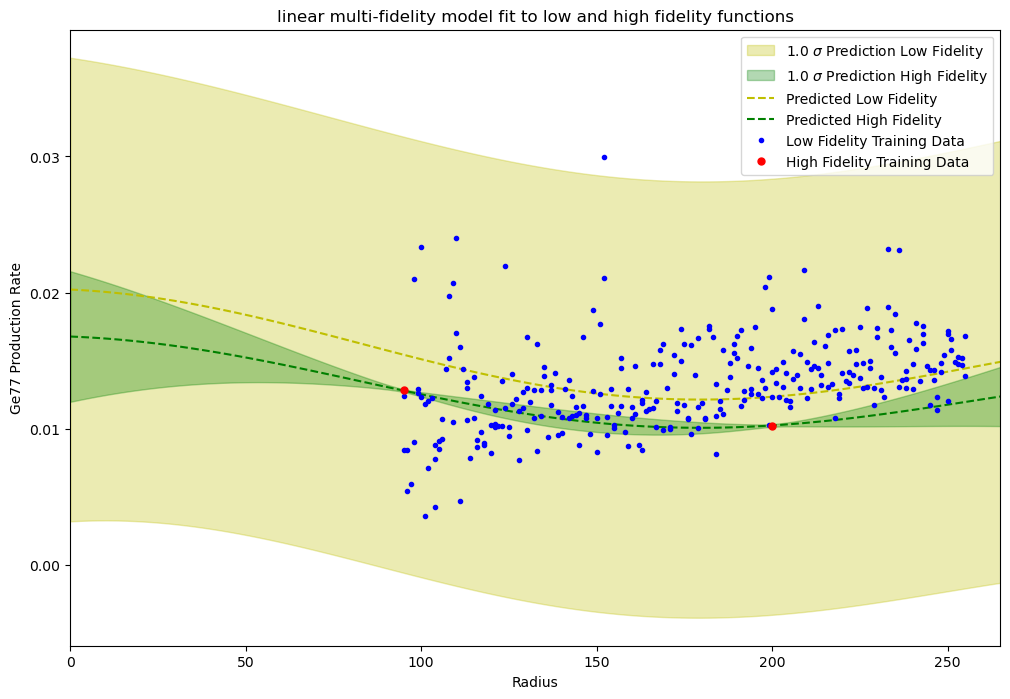

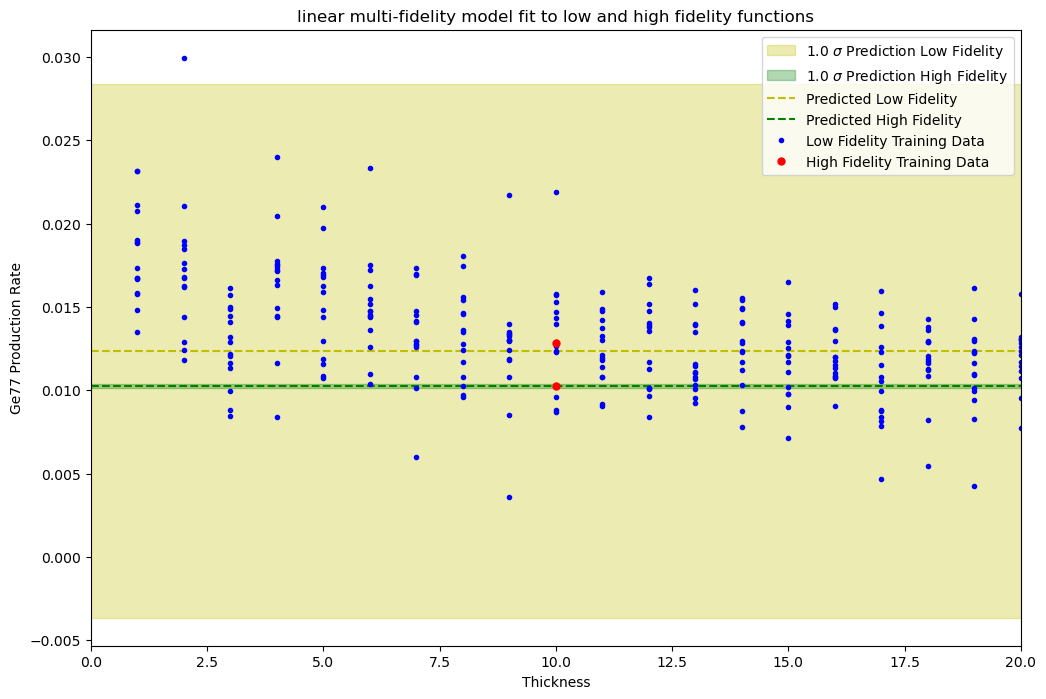

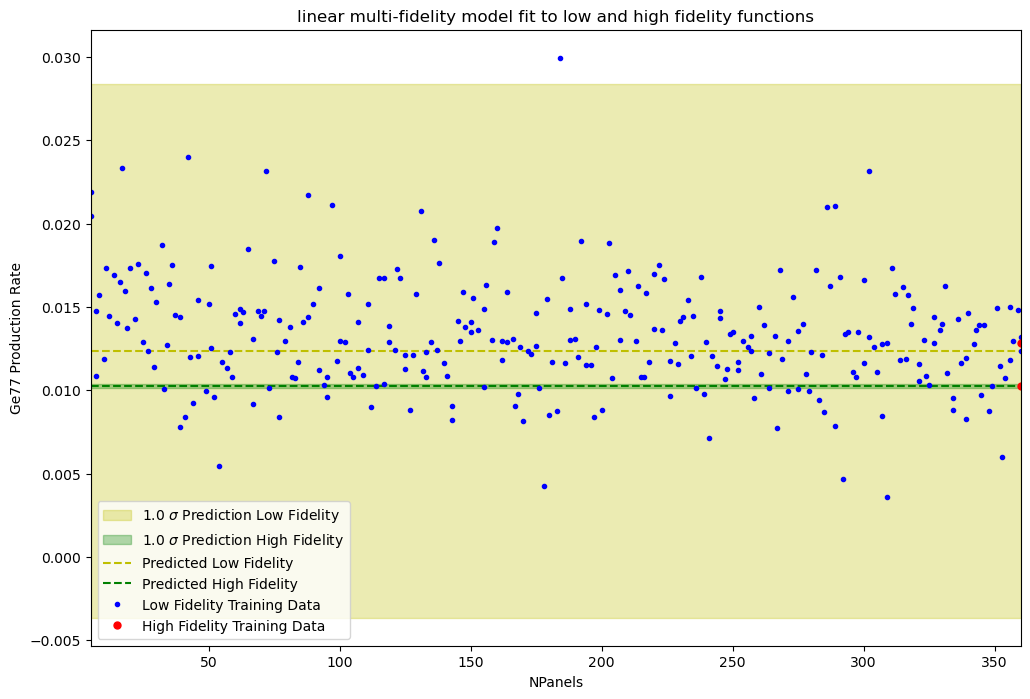

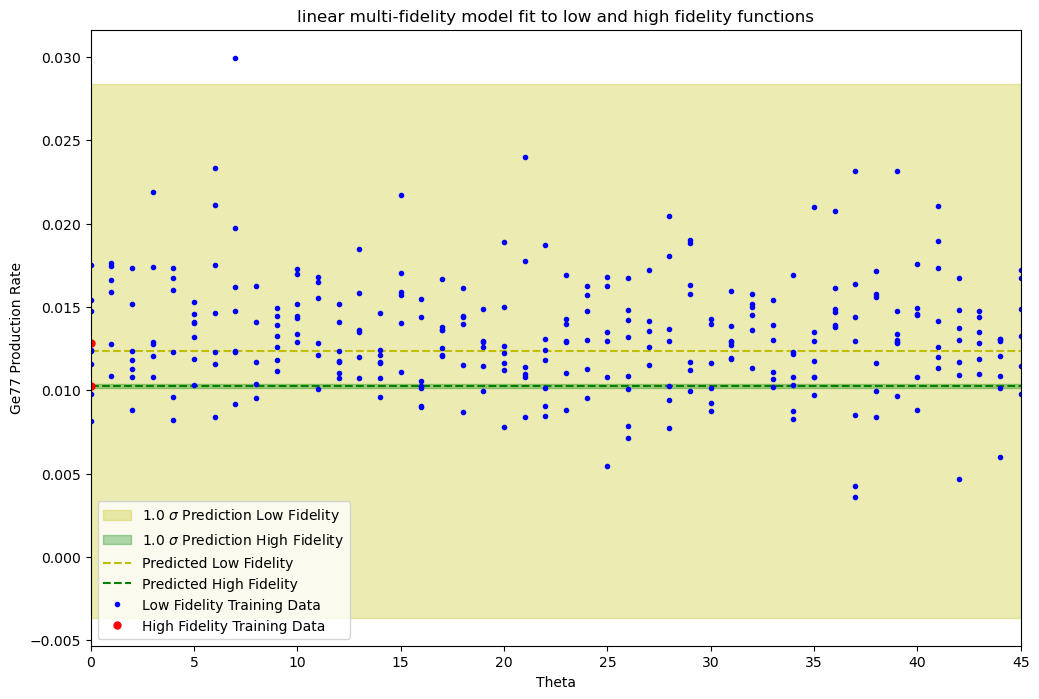

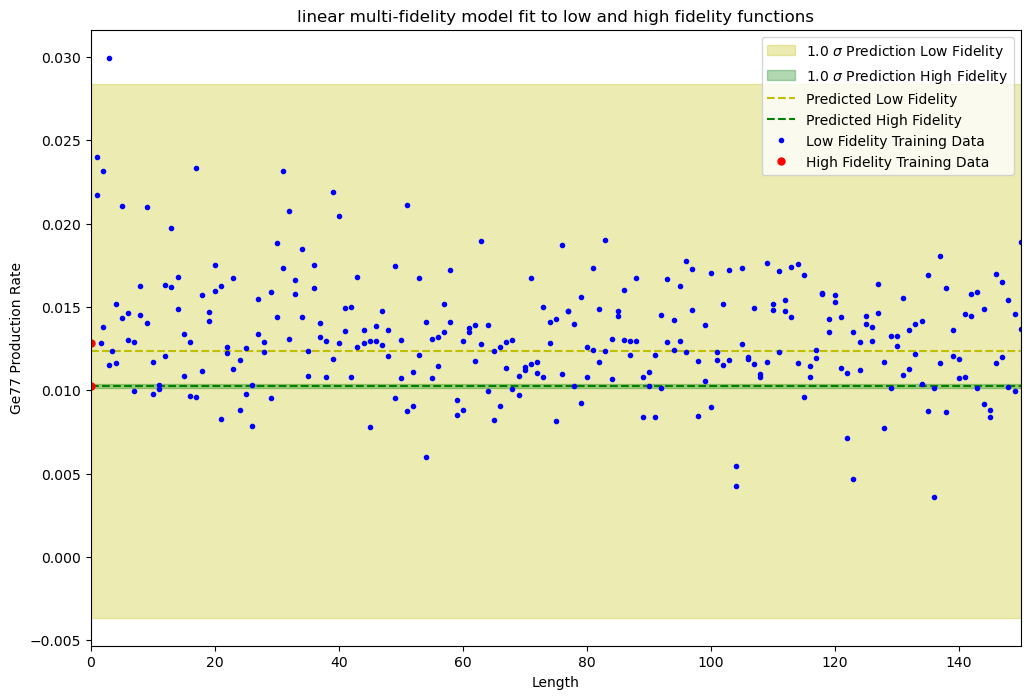

/var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_14277/2956002811.py:44: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



next suggested point to simulated is at: [160, 5, 40, 45, 100]


In [16]:
sample='n0'
x_new_data = np.array([])
y_new_data = np.array([])
factor = 1.
leg_label = []
leg_label.extend(["acquisition func",r'$x_{new}$'])
x_fixed = [160, 5, 40, 45, 100]
fig1 = [plt.figure(figsize=(12,8)) for i in range(len(xlow))]
fig2 = [plt.figure(figsize=(12,8)) for i in range(len(xlow))]
x_next_data, X_train, Y_train, x_train_h, y_train_h, fig1, fig2 = ActiveLearning(X_train, Y_train, x_train_l, y_train_l, x_train_h, y_train_h, nonlin_mf_model, xmin, xmax, xlow, xhigh, labels, factor, fig1, fig2, x_new_data, y_new_data, version, x_fixed)
simulation_utils.PrintGeant4Macro(x_next_data[0][0],x_next_data[0][1],x_next_data[0][2],x_next_data[0][3],x_next_data[0][4],sample,'LF',version)

DrawMultiFideliyModel3D(nonlin_mf_model,xmin, xmax,index1=0,index2=2,index3=4 ,labels=labels,version=version,ml='LF', x_fixed=x_fixed)

Run simulation and add first new sample

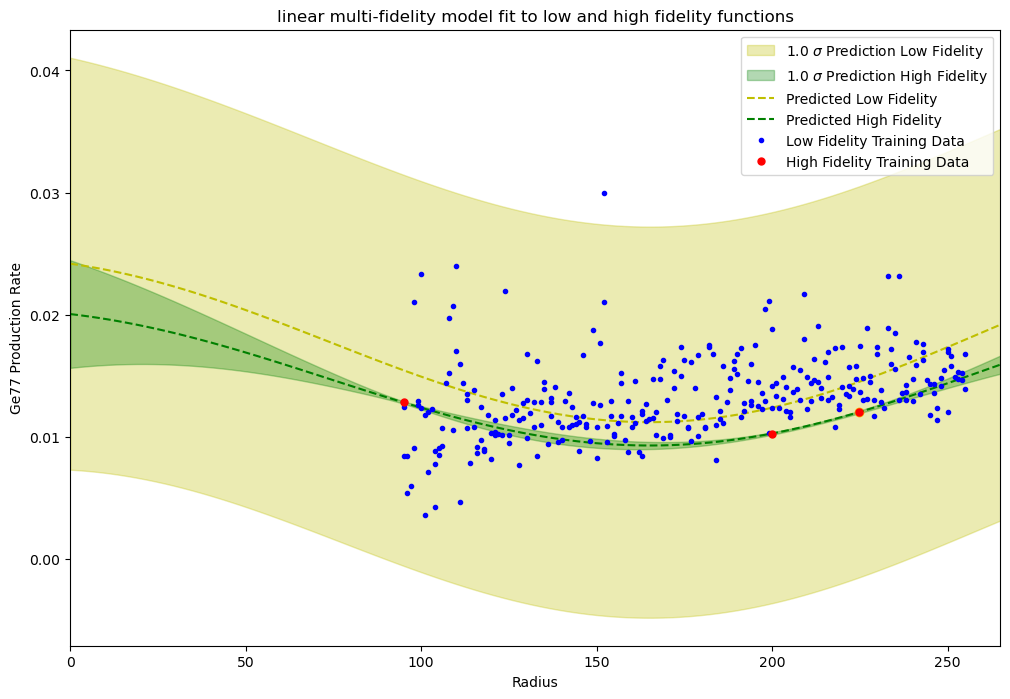

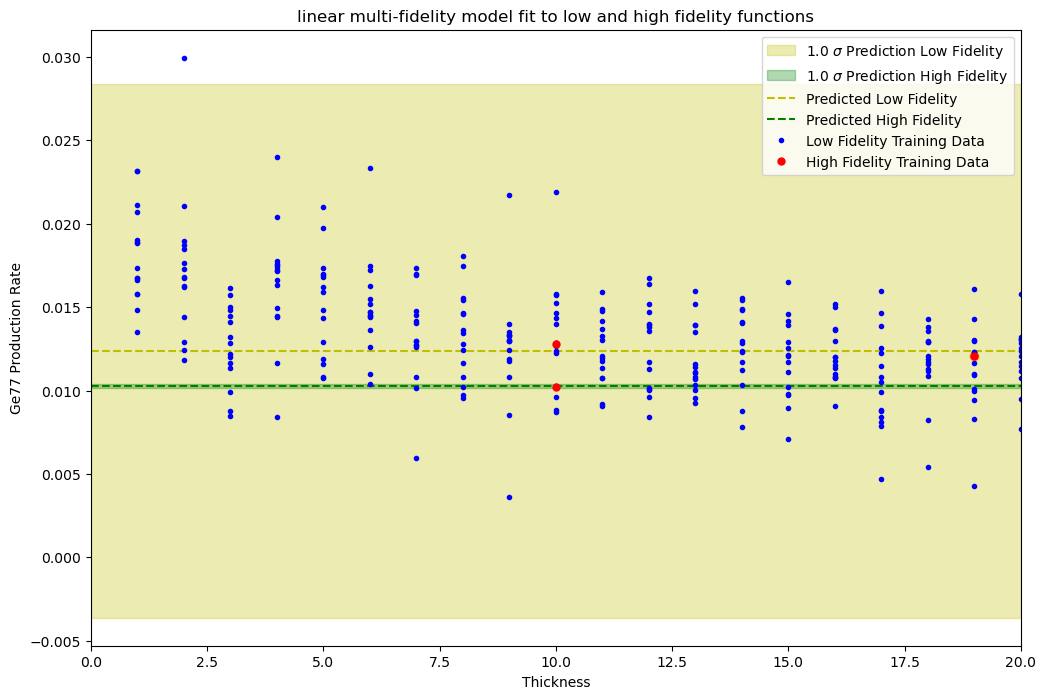

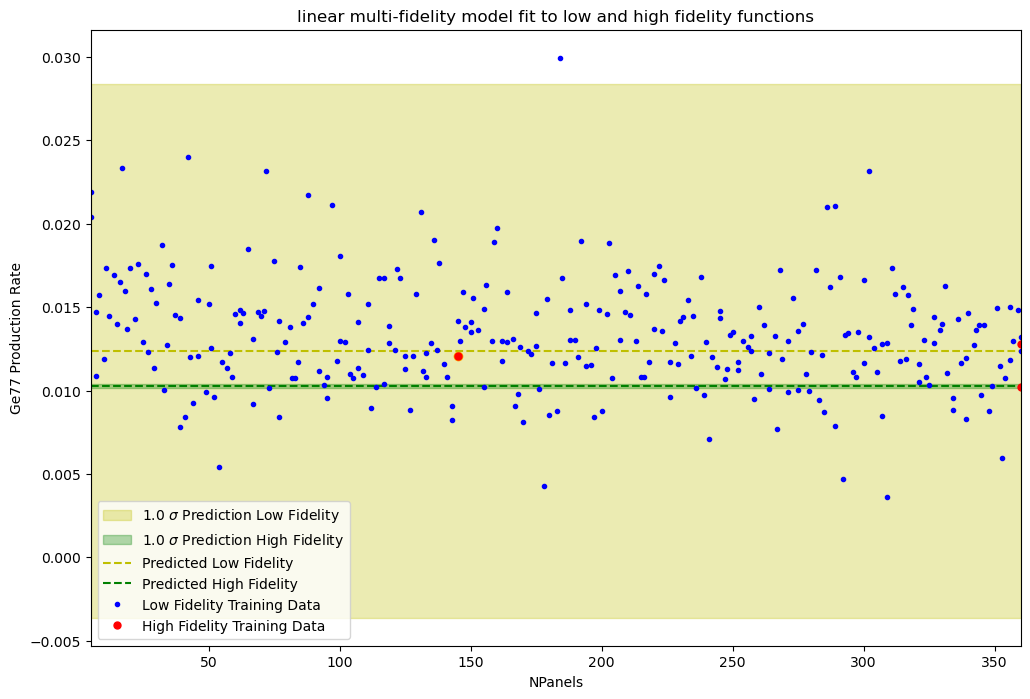

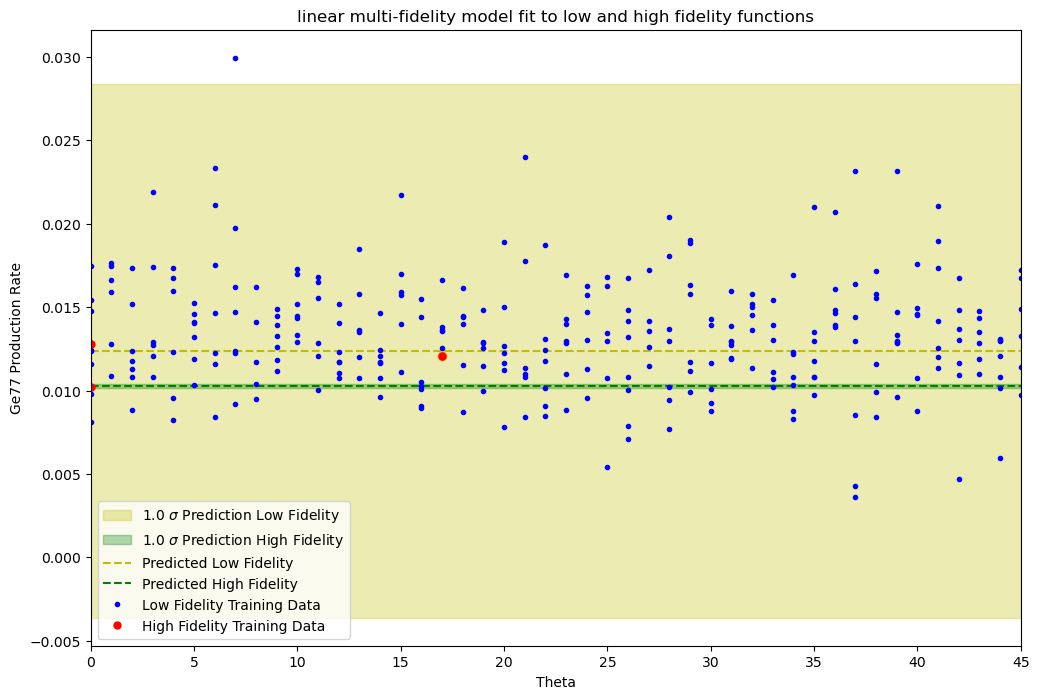

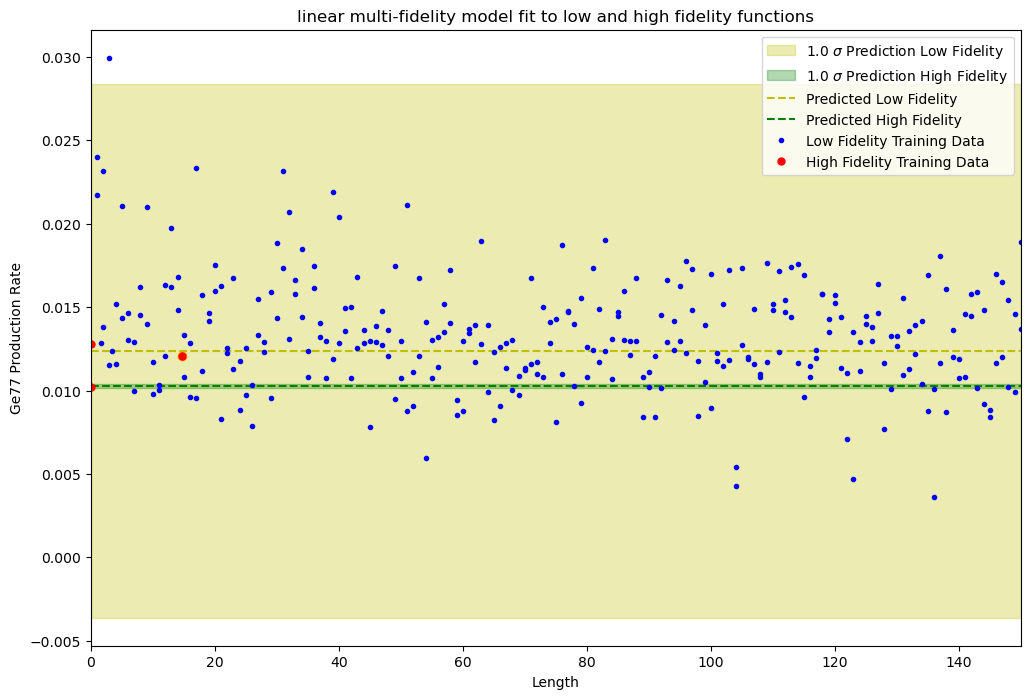

/var/folders/99/0svbmlns6xs9l9p55lcr912r0000gn/T/ipykernel_14277/2956002811.py:44: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



next suggested point to simulated is at: [160, 5, 40, 45, 100]


In [17]:

#x_next_data=[[224.7, 19.0, 145, 17.0, 14.7, 1.]]
#sample='n1'
#x_new_data = np.array(x_next_data)
# test with a first guess
#y_new_data = np.array([[0.0120430765]])
#version_updated=f"updated-new-sample-{sample}_{version}"
#leg_label.extend([f"updated acquisition func ({sample})",r'$x_{new}$'])
#factor=1.
#x_next_data, X_train, Y_train, x_train_h, y_train_h, fig1, fig2 = ActiveLearning(X_train, Y_train, x_train_l, y_train_l, x_train_h, y_train_h, nonlin_mf_model, xmin, xmax, xlow, xhigh, labels, factor, fig1, fig2, x_new_data, y_new_data, version, x_fixed)
#print(f'next suggested point to simulated is at: {x_next_data}')
#simulation_utils.PrintGeant4Macro(x_next_data[0][0],x_next_data[0][1],x_next_data[0][2],x_next_data[0][3],x_next_data[0][4],sample,'LF',version)

#DrawMultiFideliyModel3D(nonlin_mf_model,xmin, xmax,index1=0,index2=2,index3=4 ,labels=labels,version=version,ml='LF', x_fixed=x_fixed)

In [ ]:

#x_next_data=[[141.8,4.4, 289, 33.2, 62.2, 1.]]
#sample='n2'
#x_new_data = np.array(x_next_data)
# test with a first guess
#y_new_data = np.array([[0.015293]])
#version_updated=f"updated-new-sample-{sample}_{version}"
#leg_label.extend([f"updated acquisition func ({sample})",r'$x_{new}$'])
#factor=1.
#x_next_data, X_train, Y_train, x_train_h, y_train_h, fig = ActiveLearning(X_train, Y_train, x_train_l, y_train_l, x_train_h, y_train_h, nonlin_mf_model, xmin, xmax, xlow, xhigh, labels, factor, fig, x_new_data, y_new_data, version, x_fixed)
#print(f'next suggested point to simulated is at: {x_next_data}')
#simulation_utils.PrintGeant4Macro(x_next_data[0][0],x_next_data[0][1],x_next_data[0][2],x_next_data[0][3],x_next_data[0][4],sample,'LF',version)

#DrawMultiFideliyModel3D(nonlin_mf_model,xmin, xmax,index1=0,index2=2,index3=4 ,labels=labels,version=version,ml='LF', x_fixed=x_fixed)